Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Benchmark TensorRT models inference

This tutorial shows how to convert a bundle in the MONAI model zoo to a TensorRT engine script for better performance and benchmark the difference between the pytorch module and the TensorRT engine script.  
The spleen ct segmentation bundle is used as the example in this tutorial.The inference latency before and after the coverting will be compared. Feel free to modify the spleen ct segmentation bundle to any other bundles in the MONAI model zoo which support TensorRT converting. The supported bundle names are listed below.

```
spleen_ct_segmentation
endoscopic_inbody_classification
brats_mri_segmentation
breast_density_classification
pathology_nuclei_classification
pathology_tumor_detection
prostate_mri_anatomy
valve_landmarks
```

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:

import glob
import os
import shutil
import tempfile
import time

import torch
from typing import Union, Sequence, Tuple

import matplotlib.pyplot as plt
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import get_torch_version_tuple, set_determinism
from monai.bundle import get_net_input_shape
from torch.jit._script import ScriptModule

# TODO add constrain for torch-tensorrt version
print_config()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1+505.g6bb46b14
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6bb46b142126a2879edf042d4c80d1a940f9f6ae
MONAI __file__: /home/liubin/data/github_monai/export_trt_build/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.6.4
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Download the spleen bundle

In [5]:
monai.bundle.download(name="spleen_ct_segmentation", bundle_dir="./")

2023-03-05 15:14:20,157 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-03-05 15:14:20,158 - INFO - > name: 'spleen_ct_segmentation'
2023-03-05 15:14:20,158 - INFO - > bundle_dir: './'
2023-03-05 15:14:20,158 - INFO - > source: 'github'
2023-03-05 15:14:20,159 - INFO - > remove_prefix: 'monai_'
2023-03-05 15:14:20,159 - INFO - > progress: True
2023-03-05 15:14:20,159 - INFO - ---


2023-03-05 15:14:20,917 - INFO - Expected md5 is None, skip md5 check for file spleen_ct_segmentation_v0.3.8.zip.
2023-03-05 15:14:20,917 - INFO - File exists: spleen_ct_segmentation_v0.3.8.zip, skipped downloading.
2023-03-05 15:14:20,918 - INFO - Writing into directory: ..


## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Export the trt model with API

Export the downloaded bundle model to a TensorRT engine base torch script model. This may take a while for converting and will generate `model_trt_fp32.ts` and `model_trt_fp16.ts` to the `model` folder.

In [7]:
%cd spleen_ct_segmentation
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp32.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp32
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp16.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp16
%cd ..

/home/liubin/data/github_tutorial/1201-add-trt-benchmark-tutorial/tutorials/acceleration/spleen_ct_segmentation
2023-03-05 15:14:24,305 - INFO - --- input summary of monai.bundle.scripts.trt_export ---
2023-03-05 15:14:24,305 - INFO - > net_id: 'network_def'
2023-03-05 15:14:24,305 - INFO - > filepath: 'models/model_trt_fp32.ts'
2023-03-05 15:14:24,305 - INFO - > meta_file: 'configs/metadata.json'
2023-03-05 15:14:24,305 - INFO - > config_file: 'configs/inference.json'
2023-03-05 15:14:24,305 - INFO - > ckpt_file: 'models/model.pt'
2023-03-05 15:14:24,305 - INFO - > precision: 'fp32'
2023-03-05 15:14:24,305 - INFO - ---


2023-03-05 15:16:36,809 - INFO - exported to TorchScript file: models/model_trt_fp32.ts.
2023-03-05 15:16:40,688 - INFO - --- input summary of monai.bundle.scripts.trt_export ---
2023-03-05 15:16:40,688 - INFO - > net_id: 'network_def'
2023-03-05 15:16:40,688 - INFO - > filepath: 'models/model_trt_fp16.ts'
2023-03-05 15:16:40,688 - INFO - > meta_file: 'configs/metadat

## Load the torch model and TensorRT model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weight  = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "model.pt"))[0]
meta_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "metadata.*"))[0]
inference_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*","inference.*"))[0]
trt_fp32_model_path = os.path.join("./spleen_ct_segmentation", "models","model_trt_fp32.ts")
trt_fp16_model_path = os.path.join("./spleen_ct_segmentation", "models","model_trt_fp16.ts")
parser = monai.bundle.ConfigParser()
parser.read_meta(meta_config)
parser.read_config(inference_config)
# If using other bundles, the net_id may be change. Please modify this variable accordingly.
net_id = "network"
model = parser.get_parsed_content(net_id)
spatial_shape = get_net_input_shape(parser)
model = parser.get_parsed_content(net_id)
model.eval()
model.to(device)

trt_fp32_model = torch.jit.load(trt_fp32_model_path)
trt_fp16_model = torch.jit.load(trt_fp16_model_path)


## Benchmark the model inference time

In this part, we only benchmark the model inference with a random input.

Total time for the torch model: 1432.5817260742188ms. Average time for the torch model: 2.8651634521484315ms.


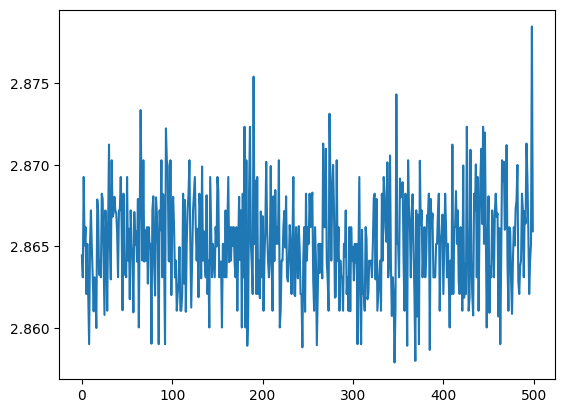

Total time for the TensorRT_fp32 model: 1092.844883441925ms. Average time for the TensorRT_fp32 model: 2.1856897668838458ms.


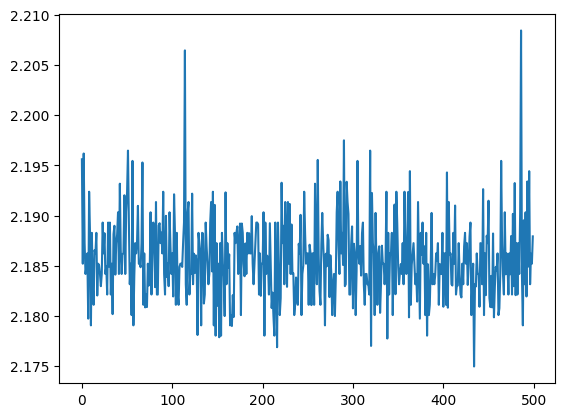

Total time for the TensorRT_fp16 model: 644.2434629201889ms. Average time for the TensorRT_fp16 model: 1.2884869258403753ms.


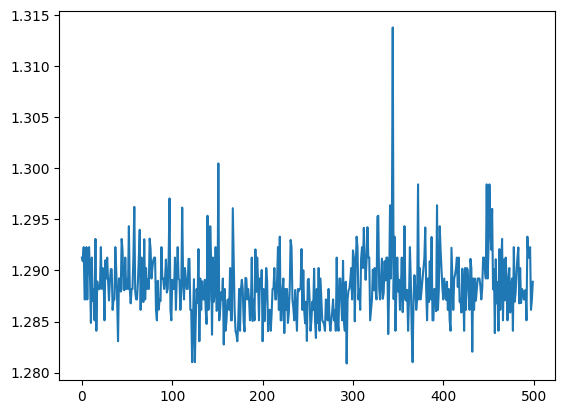

1.2884869258403753

In [9]:
def inference_random_torch_timer(model, input_shape, model_type="torch", warmup_iter=500, active_iter=500):

    is_torch_module = not isinstance(model, ScriptModule)
    with torch.no_grad():
        for _ in range(warmup_iter):
            random_input = torch.rand(input_shape, dtype=torch.float32, device=device)
            pred = model(random_input)

        timeaccumulate = []
        for _ in range(active_iter):
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            torch.cuda.synchronize()
            starter.record()
            pred = model(random_input)
            ender.record()
            torch.cuda.synchronize()
            time_cur = starter.elapsed_time(ender)
            timeaccumulate.append(time_cur)
        total_time = sum(timeaccumulate)
        average_time = total_time / (len(timeaccumulate) + 1e-12)
    print(f"Total time for the {model_type} model: {total_time}ms. Average time for the {model_type} model: {average_time}ms.")
    plt.plot(timeaccumulate)
    plt.show(model_type)
    return average_time
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Only test the fp32 precision torch model
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

inference_random_torch_timer(model, spatial_shape, model_type="torch")
inference_random_torch_timer(trt_fp32_model, spatial_shape, model_type="TensorRT_fp32")
inference_random_torch_timer(trt_fp16_model, spatial_shape, model_type="TensorRT_fp16")    